In [2]:
import MulensModel as mm
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def random_event():
    u0 = np.sqrt(np.random.uniform(0, 1))
    tE = 10**np.random.uniform(0.5, 2)   # 3 - 100 days
    rho = 10**np.random.uniform(-10, -3)
    q = 10**np.random.uniform(-5, 0)
    s = 10**np.random.uniform(-1, 1)    # 0.1 – 10
    alpha = np.random.normal(180, 40)
    
    return [u0, tE, rho, q, s, alpha]


In [105]:
# More sophisticated parameter generation
class Param:
    def __init__(self, name, pmin, pmax, init):
        self.name = name
        self.min = pmin
        self.max = pmax
        self.init = init
    
    def cutoff(self, inmin, inmax):
        x = 0
        if self.name == "u_0":
            x = np.sqrt(np.random.uniform(inmin, inmax))
        elif self.name == "alpha":
            x = np.random.normal(inmin, inmax)
        else:
            x = 10**np.random.uniform(inmin, inmax)

        if x > self.max:
            return self.max
        if x < self.min:
            return self.min
        
        return x

    def get_sample_n(self, inmin, inmax, n):
        samples = []
        labels = []
        for i in range(n):
            s = self.get_sample(inmin, inmax)
            samples.append(s[0])
            labels.append(s[1])
        return samples, labels
    
    def get_sample(self, inmin, inmax):
        x = self.cutoff(inmin, inmax)
        lab = self.get_label(x)
        return [lab, x]

    def get_label(self, x):
        return str(f"{self.name}: " + "{:.2f}".format(x))

class Params:
    def __init__(self):
        self.u_0 = Param("u_0", 0, np.sqrt(1), 0.5)
        self.t_E = Param("t_E", 3, 100, 50)
        self.rho = Param("rho", 10e-8, 10e-3, 10e-4)
        self.q = Param("q", 10e-5, 1, 10e-3)
        self.s = Param("s", -0.1, 10, 1)
        self.alpha = Param("alpha", 0, 360, 180)

    def get_vals(self, n):
        all_data = [
            self.u_0.get_sample_n(0, 1, n), self.t_E.get_sample_n(0.5, 2, n),
            self.rho.get_sample_n(-10, -3, n), self.q.get_sample_n(-5, 0, n), 
            self.s.get_sample_n(-1, 1, n), self.alpha.get_sample_n(180, 40, n)
        ]
        vals = [dat[1] for dat in all_data]
        labels = [dat[0] for dat in all_data]
        return vals, labels
    
    def get_vals(self):
        all_data = [
            self.u_0.get_sample(0, 1), self.t_E.get_sample(0.5, 2),
            self.rho.get_sample(-10, -3), self.q.get_sample(-5, 0), 
            self.s.get_sample(-1, 1), self.alpha.get_sample(180, 40)
        ]
        vals = [dat[1] for dat in all_data]
        labels = [dat[0] for dat in all_data]
        return vals, labels

In [89]:
u_0 = Param("u_0", 0, np.sqrt(1), 0.5)
print(u_0)
print(u_0.get_sample_n(0, 1, 1))

(['u_0: 0.64'], [np.float64(0.6364900097225132)])


In [102]:
def get_curve(args):
    my_1S2L_model = mm.Model({'t_0': 2452848.06, 'u_0': args[0],
                              't_E': args[1], 'rho': args[2], 'q': args[3], 's': args[4],
                              'alpha': args[5]})
    lc = my_1S2L_model.get_lc(t_range=[2452810, 2452890], source_flux=1)
    return np.arange(len(lc)), lc

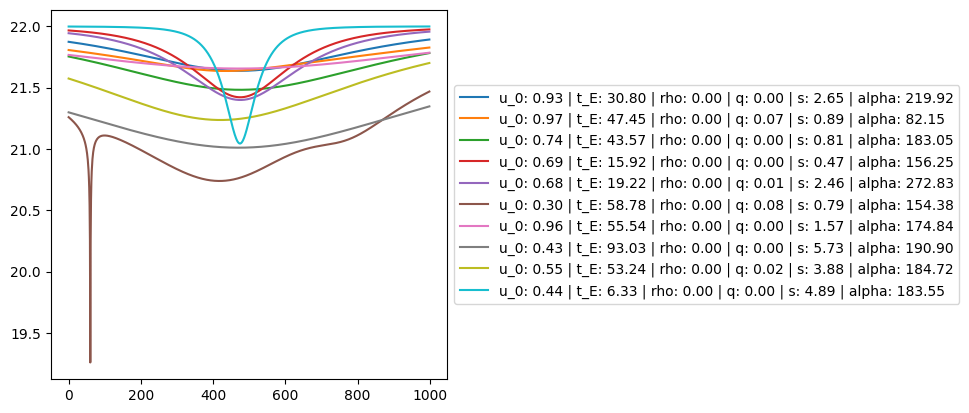

In [110]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(10):
    params = Params()
    args, labels = params.get_vals()
    x, y = get_curve(args)
    ax.plot(x, y, label=' | '.join(labels))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [41]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider


# The parametrized function to be plotted
def f(u_0, t_E, rho, q, s, alpha):
    my_1S2L_model = mm.Model({'t_0': 2452848.06, 'u_0': u_0,
                              't_E': t_E, 'rho': rho, 'q': q, 's': s,
                              'alpha': alpha})
    lc = my_1S2L_model.get_lc(t_range=[2452810, 2452890], source_flux=1)

t = np.linspace(0, 1, 1000)


# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(inits["u_0"], inits["t_E"], inits["rho"], inits["q"], inits["s"], inits["alpha"]), lw=2)
ax.set_xlabel('Time [HJD]')
ax.set_ylabel('Magnitude [mag]')
# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
u0_slider = Slider(
    ax=axfreq,
    label='Impact Param',
    valmin=0,
    valmax=1,
    valinit=inits["u_0"],
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Source/Einstein Ring",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

TypeError: Param() takes no arguments